# V471TAU

## Differential Rotation 

The parameters that will be used in each epoch are:

|           Parameter   | 2004       |  2005     |
|              :---:    | :---:      | :---:     |
|$K$ (km/s)             | $149.4$    | $149.4$   |  
|$v_\mathrm{rad}$ (km/s)| $34.7$     | $35.0$    |
|$\phi$                 | $-0.0029$  | $-0.0041$ | 
| $i$                   | $80$       | $80$      |
|$v\sin(i)$ (km/s)      | $90.1$     |  $90.1$   |
| EQW                   | $5.12$     | $5.12$    |

Also, we keep $\chi^2_{\mathrm{aim}} = 0.32 $ as used since the beginning. 

### DATA IN 2004  

In [12]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search1_dr_i_2004.txt', unpack=True)

# Set global min of spot coverage
vmin = sp_ph.min()

#select data within the conditions:
ic = N.bitwise_and(chisq <= 0.3005, test <= 0.003)
beta = beta[ic]; gamma = gamma[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]
#we also add another condition for the data (optional):
level = 1.05
isp = N.bitwise_and(sp_ph >= 1.00*vmin, sp_ph <= level*vmin)
beta = beta[isp]; gamma = gamma[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Set max of spot coverage
vmax = sp_ph.max()

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(beta), N.unique(gamma))
m_z = N.ones_like(x)*9999.

for i in range(sp_ph.shape[0]):
    indx = N.bitwise_and(x == beta[i], y == gamma[i])
    m_z[indx] = sp_ph[i]
    
mask = m_z > level*vmin
z=N.ma.array(m_z, mask=mask)  
# find center in the 2d-plane
optimize_func = lambda x: x[0]*beta**2 + x[1]*beta + x[2]*gamma**2 + x[3]*gamma \
                            + x[4]*beta*gamma + x[5] - sp_ph
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
print('Position of the center on this plane:')
print('beta = %6.4f and gamma = %6.4f' %(best_x, best_y))
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
print(r'Omega_EQ = %4.3f and dO = %4.3f' %((1-best_x)*Omega0, best_y*Omega0))

Position of the center on this plane:
beta = -0.0039 and gamma = 0.0076
Omega_EQ = 12.103 and dO = 0.091


In [13]:
# Read file with informations in each run
beta_v, gamma_v, chisq_v, s_v, bmod, test_v = N.genfromtxt('data/search1_dr_v_2004.txt', unpack=True)

# Set global min of spot coverage
vmin_v = bmod.min()

#select data within the conditions:
ic = N.bitwise_and(chisq_v <= 1.0205, test_v <= 0.03)
beta_v = beta_v[ic]; gamma_v = gamma_v[ic]; chisq_v = chisq_v[ic]; s_v = s_v[ic]; bmod = bmod[ic] 
test_v = test_v[ic]
#we also add another condition for the data (optional):
level = 50.
isp = N.bitwise_and(bmod >= 1.00*vmin_v, bmod <= level*vmin_v)
beta_v = beta_v[isp]; gamma_v = gamma_v[isp]; chisq_v = chisq_v[isp]; s_v = s_v[isp]; bmod = bmod[isp] 
test_v = test_v[isp]

# Set max of bfield 
vmax_v = N.max(N.abs(bmod))

# Create a mesh and create new matrix with mesh's shape
x_v, y_v = N.meshgrid(N.unique(beta_v), N.unique(gamma_v))
m_z_v = N.ones_like(x_v)*9999.

for i in range(bmod.shape[0]):
    indx = N.bitwise_and(x_v == beta_v[i], y_v == gamma_v[i])
    m_z_v[indx] = bmod[i]
    
mask_v = m_z_v > level*vmin_v
z_v=N.ma.array(m_z_v, mask=mask_v)  
# find center in the 2d-plane
optimize_func = lambda x: x[0]*beta_v**2 + x[1]*beta_v + x[2]*gamma_v**2 + x[3]*gamma_v \
                            + x[4]*beta_v*gamma_v + x[5] - bmod
coef_v = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef_v.copy()
best_x_v = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y_v = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
print('Position of the center on this plane:')
print('beta = %6.4f and gamma = %6.4f' %(best_x_v, best_y_v))
print(r'Omega_EQ = %4.3f and dO = %4.3f' %((1-best_x_v)*Omega0, best_y_v*Omega0))

Position of the center on this plane:
beta = -0.0054 and gamma = 0.0121
Omega_EQ = 12.120 and dO = 0.146


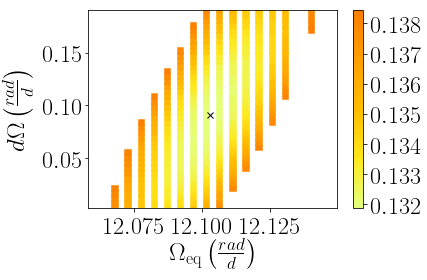

In [14]:
cmap = plt.get_cmap('Wistia', 35)
P.rcParams['font.family'] = 'arial'
# with stokes-I
Oeq = (1 - x)*Omega0
dO = y*Omega0
P.scatter(Oeq, dO, c=z, marker = 's', s=40, cmap=cmap, vmin = vmin, vmax = vmax)
#P.contour(Oeq, dO, z, 20, colors='g', alpha=0.5)#, levels = N.linspace(vmin, vmax, 8), cmap=cmap)
P.colorbar()
P.plot((1-best_x)*Omega0, best_y*Omega0, 'x', color='k')
# with stokes-V
Oeq_v = (1 - x_v)*Omega0
dO_v = y_v*Omega0
#P.scatter(Oeq_v, dO_v, c=z_v, marker = 's', s=20, cmap=cmap, vmin = vmin_v, vmax = vmax_v)
#P.contour(Oeq_v, dO_v, z_v, 20, colors='r', alpha=0.5) #levels = N.linspace(vmin_v, vmax_v, 8), cmap=cmap)
#P.plot((1-best_x_v)*Omega0, best_y_v*Omega0, 'x', color='k')
P.xlim((Oeq_v.min(), Oeq_v.max()))
P.ylim((dO_v.min(), dO_v.max()))
P.xlabel(r'$\Omega_\mathrm{eq} \left(\frac{rad}{d}\right)$')
P.ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$')
P.tight_layout()

### DATA IN 2005  

In [4]:
# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search1_dr_i_2005.txt', unpack=True)

# Set global min of spot coverage
vmin = sp_ph.min()

#select data within the conditions:
ic = N.bitwise_and(chisq <= 0.3605, test <= 0.003)
beta = beta[ic]; gamma = gamma[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]
#we also add another condition for the data (optional):
isp = N.bitwise_and(sp_ph >= 1.00*vmin, sp_ph <= level*vmin)
beta = beta[isp]; gamma = gamma[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Set max of spot coverage
vmax = sp_ph.max()

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(beta), N.unique(gamma))
m_z = N.ones_like(x)*9999.

for i in range(sp_ph.shape[0]):
    indx = N.bitwise_and(x == beta[i], y == gamma[i])
    m_z[indx] = sp_ph[i]
    
mask = m_z > level*vmin
z=N.ma.array(m_z, mask=mask)  
# find center in the 2d-plane
optimize_func = lambda x: x[0]*beta**2 + x[1]*beta + x[2]*gamma**2 + x[3]*gamma \
                            + x[4]*beta*gamma + x[5] - sp_ph
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
print('Positions of the center in this plane:')
print('beta = %6.4f and gamma = %6.4f' %(best_x, best_y))
print(r'Omega_EQ = %4.3f and dO = %4.3f' %((1-best_x)*Omega0, best_y*Omega0))

Positions of the center in this plane:
beta = -0.0029 and gamma = 0.0059
Omega_EQ = 12.090 and dO = 0.072


In [5]:
# Read file with informations in each run
beta_v, gamma_v, chisq_v, s_v, bmod, test_v = N.genfromtxt('data/search1_dr_v_2005.txt', unpack=True)

# Set global min of spot coverage
vmin_v = bmod.min()

#select data within the conditions:
ic = N.bitwise_and(chisq_v <= 1.0705, test_v <= 0.003)
beta_v = beta_v[ic]; gamma_v = gamma_v[ic]; chisq_v = chisq_v[ic]; s_v = s_v[ic]; bmod = bmod[ic] 
test_v = test_v[ic]
#we also add another condition for the data (optional):
level = 1.05
isp = N.bitwise_and(bmod >= 1.00*vmin_v, bmod <= level*vmin_v)
beta_v = beta_v[isp]; gamma_v = gamma_v[isp]; chisq_v = chisq_v[isp]; s_v = s_v[isp]; bmod = bmod[isp] 
test_v = test_v[isp]

# Set max of spot coverage
vmax_v = N.max(N.abs(bmod))

# Create a mesh and create new matrix with mesh's shape
x_v, y_v = N.meshgrid(N.unique(beta_v), N.unique(gamma_v))
m_z_v = N.ones_like(x_v)*9999.

for i in range(bmod.shape[0]):
    indx = N.bitwise_and(x_v == beta_v[i], y_v == gamma_v[i])
    m_z_v[indx] = bmod[i]
    
mask_v = m_z_v > level*vmin_v
z_v=N.ma.array(m_z_v, mask=mask_v)  
# find center in the 2d-plane
optimize_func = lambda x: x[0]*beta_v**2 + x[1]*beta_v + x[2]*gamma_v**2 + x[3]*gamma_v \
                            + x[4]*beta_v*gamma_v + x[5] - bmod
coef_v = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef_v.copy()
best_x_v = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y_v = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
print('Position of the center on this plane:')
print('beta = %6.4f and gamma = %6.4f' %(best_x_v, best_y_v))
print(r'Omega_EQ = %4.3f and dO = %4.3f' %((1-best_x_v)*Omega0, best_y_v*Omega0))

Position of the center on this plane:
beta = -0.0026 and gamma = 0.0052
Omega_EQ = 12.087 and dO = 0.063


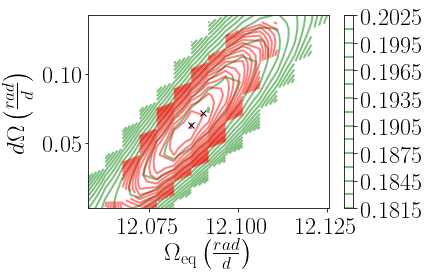

In [6]:
period =  0.521183398 # in days
Omega0 = 2*N.pi/period
Oeq = (1 - x)*Omega0
dO = y*Omega0
#P.scatter(Oeq,dO,c=z, marker = 's', s=40, cmap=cmap, vmin = vmin, vmax = vmax)
P.contour(Oeq, dO, z, 20, colors='g', alpha=0.5)#, levels = N.linspace(vmin, vmax, 8), cmap=cmap)
P.colorbar()
P.xlim((Oeq.min(), Oeq.max()))
P.ylim((dO.min(), dO.max()))
P.plot((1-best_x)*Omega0, best_y*Omega0, 'x', color='k')
# with stokes-V
Oeq_v = (1 - x_v)*Omega0
dO_v = y_v*Omega0
#P.scatter(Oeq_v, dO_v, c=z_v, marker = 's', s=20, cmap=cmap, vmin = vmin_v, vmax = vmax_v)
P.contour(Oeq_v, dO_v, z_v, 20, colors='r', alpha=0.5)#, levels = N.linspace(vmin_v, vmax_v, 8), cmap=cmap)
P.plot((1-best_x_v)*Omega0, best_y_v*Omega0, 'x', color='k')
P.xlabel(r'$\Omega_\mathrm{eq} \left(\frac{rad}{d}\right)$')
P.ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$')
P.tight_layout()


In [7]:
period =  0.521183398 # in days
Omega0 = 2*N.pi/period


In [8]:
Omega0

12.055612921076941

In [9]:
0.091-0.056


0.034999999999999996

In [10]:
12.102-12.089

0.0129999999999999

In [11]:
0.013/0.035

0.3714285714285714